In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dame_flame
import scipy.stats as stats

In [42]:
df = pd.read_csv('cleaned_data')
# apply exclusion criteria to remove outliers
df = df[~(
    (df['sbp'] < 90) | (df['sbp'] > 200) |
    (df['tc'] < 130) | (df['tc'] > 320) |
    (df['hdlc'] < 20) | (df['hdlc'] > 100) |
    (df['bmi'] < 18.5) | (df['bmi'] >= 40)
)]

In [43]:
# check missing (already processed so no missing is expected)
df.isna().sum()

patid                    0
index_date               0
scre                     0
sbp                      0
bmi                      0
tc                       0
hdlc                     0
smoker                   0
antihtn                  0
diabetes                 0
mi                       0
stroke                   0
hf                       0
cvd                      0
ascvd                    0
date_of_birth            0
race                     0
ethnicity                0
sex                      0
age                      0
high_school_education    0
median_income            0
no_health_insurance      0
deprivation_index        0
dtype: int64

## Matching

In [44]:
# vars to use for matching: lab, vitals, demographic, and sdoh
matching_vars = ['scre', 'sbp', 'bmi', 'hdlc', 'smoker', 'race', 'sex', 'age', 'deprivation_index']

# get a copy
for_matching = df[matching_vars + ['diabetes', 'cvd']].copy()

# convert to numerical
for col in ['sex', 'race']:
    for_matching[col] = pd.Categorical(for_matching[col]).codes
    
# to numerical
for_matching["sex"] = (df["sex"] == "Male").astype(int)

In [45]:
# drop index
if 'index' in for_matching.columns:
    for_matching = for_matching.drop('index', axis=1)

# then reset
for_matching = for_matching.reset_index(drop=True)

print(f"Data prepared for matching, shape: {for_matching.shape}")
print(f"Columns for matching: {for_matching.columns.tolist()}")

Data prepared for matching, shape: (10838, 11)
Columns for matching: ['scre', 'sbp', 'bmi', 'hdlc', 'smoker', 'race', 'sex', 'age', 'deprivation_index', 'diabetes', 'cvd']


In [46]:
# init dame model
model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True)

# fit
model.fit(
    for_matching,
    treatment_column_name="diabetes",
    outcome_column_name="cvd"
)

# get result
result = model.predict(for_matching)

Completed iteration 0 of matching
	Number of matched groups formed in total:  1
	Unmatched treated units:  1334 out of a total of  1335 treated units
	Unmatched control units:  9502 out of a total of  9503 control units
	Number of matches made this iteration:  2
	Number of matches made so far:  2
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.22521112156440143
Completed iteration 1 of matching
	Number of matched groups formed in total:  1
	Unmatched treated units:  1334 out of a total of  1335 treated units
	Unmatched control units:  9502 out of a total of  9503 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  2
	Covariates dropped so far:  frozenset({'deprivation_index'})
	Predictive error of covariate set used to match:  0.22521112156440143
Completed iteration 2 of matching
	Number of matched groups formed in total:  2
	Unmatched treated units:  1333 out of a total of  1335 treated units
	Unmatched cont

In [47]:
# helper function from hw
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

# get matched data
matched_df = get_dataframe(model, result)

## ATE and 95% CI

In [48]:
# keep only matched
matched_df = matched_df.dropna(subset=["match_group"])

# split
treated = matched_df[matched_df["diabetes"] == 1]
control = matched_df[matched_df["diabetes"] == 0]

# get weighted mean
treated_mean = np.average(treated["cvd"], weights=treated["weights"])
control_mean = np.average(control["cvd"], weights=control["weights"])

# ATE
ate = treated_mean - control_mean

# se
treated_var = np.average((treated["cvd"] - treated_mean)**2, weights=treated["weights"])
control_var = np.average((control["cvd"] - control_mean)**2, weights=control["weights"])
se = np.sqrt(treated_var / treated["weights"].sum() + control_var / control["weights"].sum())

# 95% CI
ci_lower = ate - 1.96 * se
ci_upper = ate + 1.96 * se

# print
print(f"Matched ATE: {ate:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

Matched ATE: 0.0322
95% CI: [0.0074, 0.0570]


## Matched Data Plot

In [ ]:
# restore labels
matched_df["sex"] = matched_df["sex"].apply(lambda x: "Male" if x == 1 else "Female")
matched_df["race"] = pd.Categorical.from_codes(
    codes=matched_df["race"].astype(int),
    categories=df["race"].astype("category").cat.categories
)

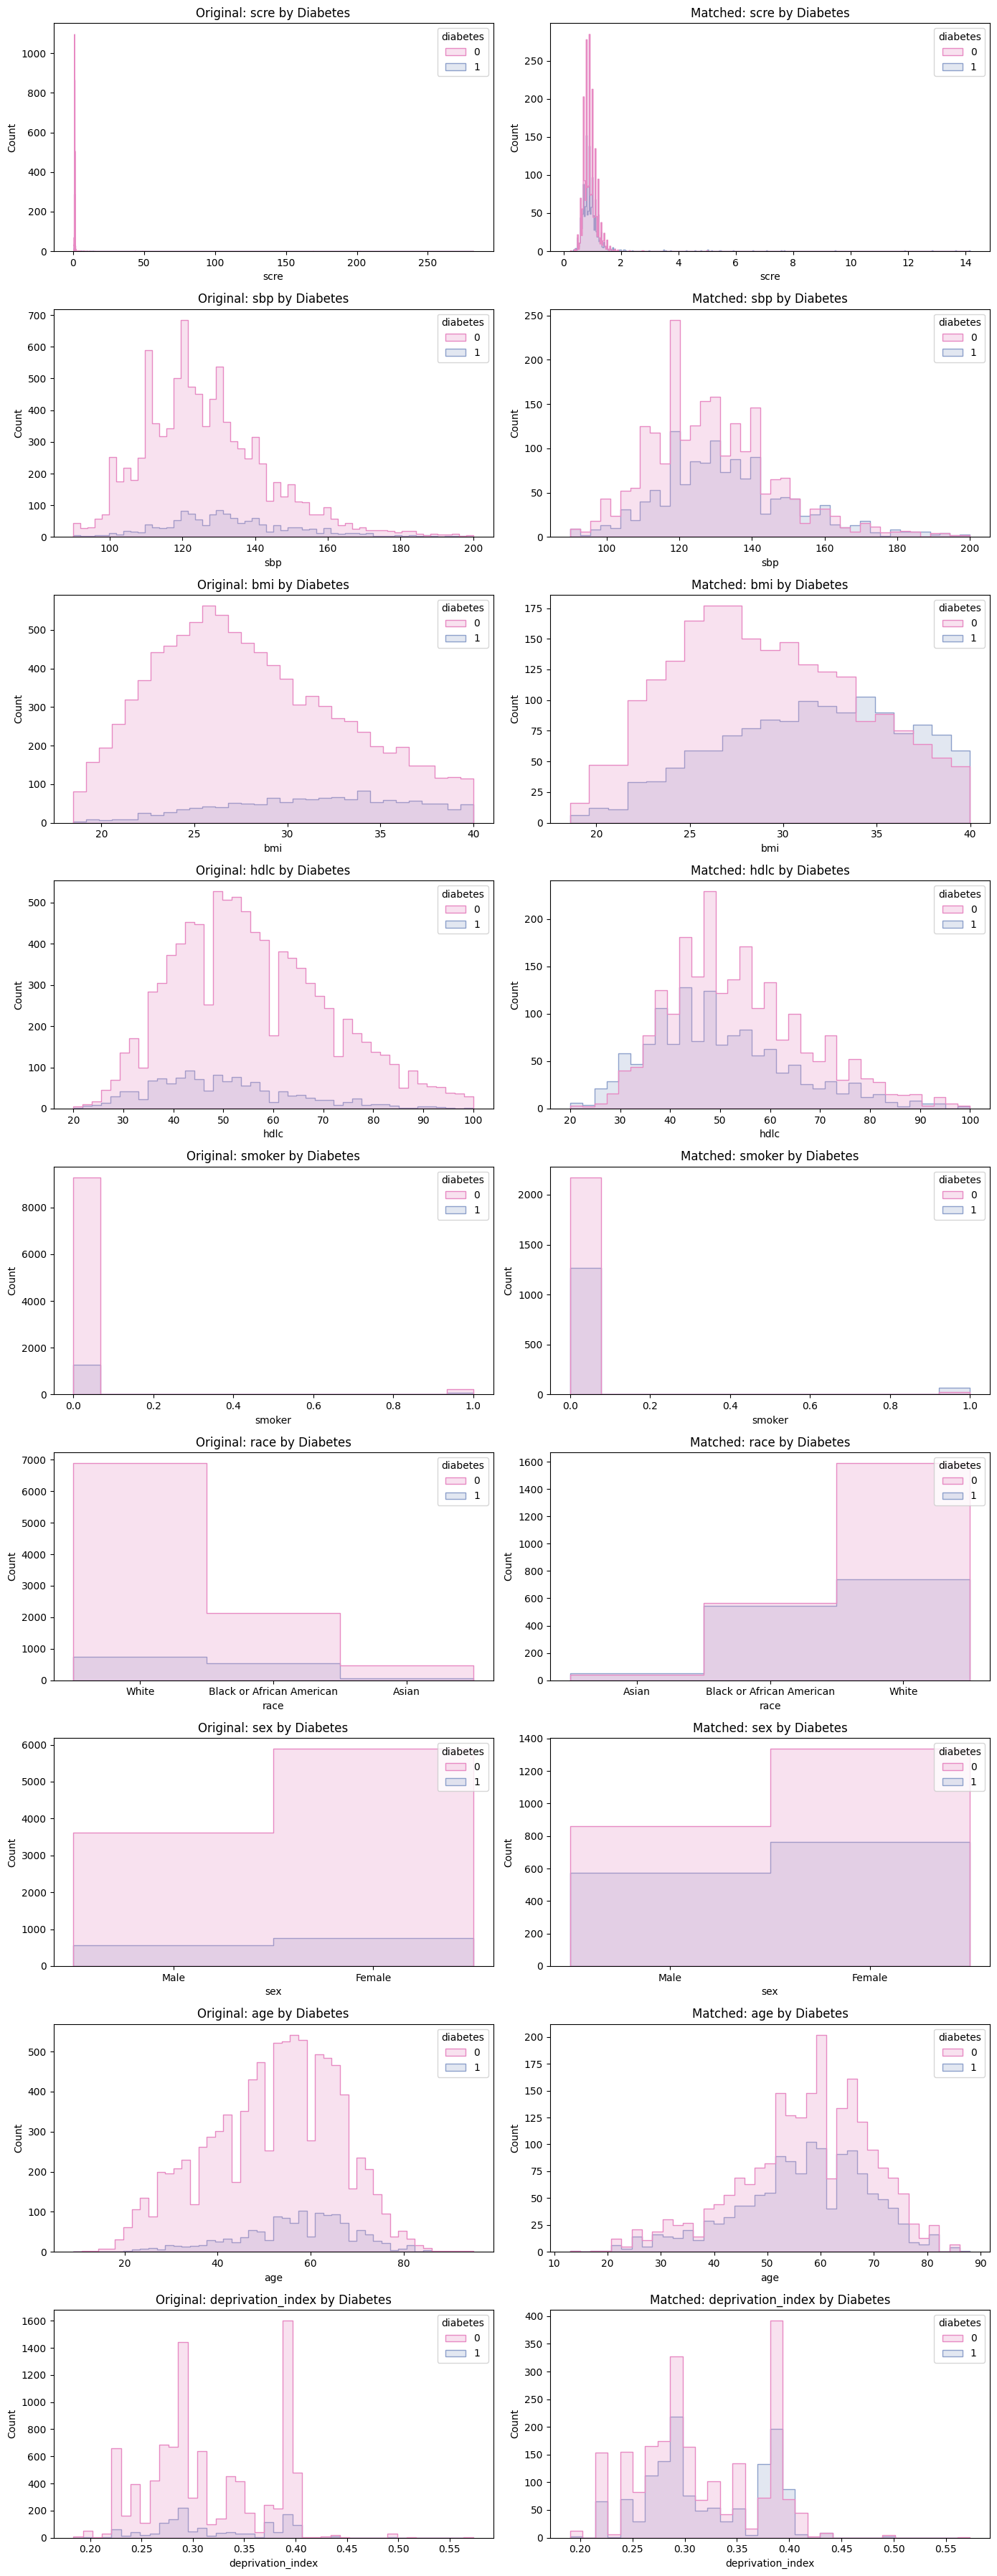

In [53]:
# variables to plot
variables = ['scre', 'sbp', 'bmi', 'hdlc', 'smoker', 'race', 'sex', 'age', 'deprivation_index']
n_vars = len(variables)

# Create plots
fig, axes = plt.subplots(n_vars, 2, figsize=(14, 4 * n_vars))
fig.subplots_adjust(hspace=0.5)

for i, var in enumerate(variables):
    # Original
    sns.histplot(data=df, x=var, hue='diabetes', element='step', stat='count', common_norm=False,
                 palette=['#e78ac3', '#8da0cb'], ax=axes[i, 0])
    axes[i, 0].set_title(f'Original: {var} by Diabetes')
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel("Count")

    # Matched
    sns.histplot(data=matched_df, x=var, hue='diabetes', element='step', stat='count', common_norm=False,
                 palette=['#e78ac3', '#8da0cb'], ax=axes[i, 1])
    axes[i, 1].set_title(f'Matched: {var} by Diabetes')
    axes[i, 1].set_xlabel(var)
    axes[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()